# Case Study

Time given: 2 days

Given purchase history data from an electronics store, create a Jupyter notebook to cover the following:
1. How would you prepare the data for analysis?
2. What insights can you glean just by exploring the data?
3. Segment the customers into groups; identify what differentiates each segment.
4. What promotions can you recommend to each segment?
5. What other promotions can you recommend based on customer behavior?

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pylab as plb

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import (KElbowVisualizer, 
    InterclusterDistance)

import warnings


params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large'}

plb.rcParams.update(params)
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
sns.set_palette("muted")

CLR = '#597dbf'

warnings.filterwarnings("ignore")

# Load Data

In [2]:
df = pd.read_csv('kz.csv')
print(df.shape)
df.head(3)

(2633521, 8)


,event_time,order_id,product_id,category_id,category_code,brand,price,user_id
0,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
1,2020-04-24 11:50:39 UTC,2294359932054536986,1515966223509089906,2.268105e+18,electronics.tablet,samsung,162.01,1.515916e+18
2,2020-04-24 14:37:43 UTC,2294444024058086220,2273948319057183658,2.268105e+18,electronics.audio.headphone,huawei,77.52,1.515916e+18


# Preprocessing

1. Check and fix data types and remove duplicates
2. Check and fix missing and unexpected values
3. Create features

### Check and fix data types and remove duplicates

In [3]:
# FIX DATA TYPES
display(df.dtypes)
df['event_time'] = pd.to_datetime(df.event_time, format='%Y-%m-%d %H:%M:%S %Z')

# REMOVE DUPLICATES
print('No. of duplicated records across all columns: ', df.duplicated().sum())
df.drop_duplicates(inplace=True)

df['event_date'] = df.event_time.dt.date
print('Are there duplicated order_ids in different dates: ', 
    'No' if df.groupby('order_id').event_date.agg('nunique').max() == 1 else 'Yes')

event_time        object
order_id           int64
product_id         int64
category_id      float64
category_code     object
brand             object
price            float64
user_id          float64
dtype: object

No. of duplicated records across all columns:  675
Are there are duplicated orer_ids in different dates:  No


### Check for and fix missing and unlikely values


In [4]:
# CHECK FOR MISSING VALUES
def get_percent_null(df):
    x = df.isnull().sum()*100 / len(df)
    return display(x[x>0].to_frame('precent_nulls'))

get_percent_null(df)

na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', 
    '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 
    'NaN', 'n/a', 'nan', 'null', 'None', 'none', 'na']

print('Check if there are other types of missing values:')
for x in na_values:
    df_ = (df == x).sum()
    if df_.sum() > 0:
        print(f'The ff column(s): {df_[df_ > 0].index.to_list()} contain(s) ', f'"{x}"') 

# Replace 'none' (0.5%) to nan or 'others' in 'brand' column?
df.brand.replace('none', np.nan, inplace=True)

,precent_nulls
category_id,16.406315
category_code,23.246821
brand,19.217417
price,16.406315
user_id,78.597495


Check if there are other types of missing values:
The ff column(s): ['brand'] contain(s)  "none"


To simplify this case study and since we are interested in segmenting customers, drop all records without `user_id`.


In [5]:
df = df[df.user_id.notnull()]

get_percent_null(df)

,precent_nulls
category_code,22.932058
brand,5.357457


Also, since we would probably need `category_code` and `brand` for segmentation, drop all records with missing values.

In [6]:
df.dropna(inplace=True)

In [7]:
# CHECK FOR UNLIKELY VALUES

# Retain 2020 records only, 0.20% of remaining records are dated 1970
display(df.groupby(df.event_time.dt.year).size())
df = df[df.event_time.dt.year==2020]

# More unique order_ids than event_times? Perhaps the store has multiple counters?
display(df.nunique())

# 119 records wherein price is 0
print('Check minimum price on record: ', df.price.min())
df = df[df.price > 0]

event_time
1970       827
2020    417417
dtype: int64

event_time       323410
order_id         330350
product_id        11391
category_id         345
category_code       123
brand               569
price              1932
user_id           90652
event_date          322
dtype: int64

Check minimum price on record:  0.0


### Add features

In [8]:
# Add time features
df['event_month'] = df.event_time.dt.month
df['event_week'] = df.event_time.dt.week
df['event_weekday'] = df.event_time.dt.weekday + 1
df['event_day'] = df.event_time.dt.day

# Add category features
df[['category_code_1', 'category_code_2', 'category_code_3']] = \
    pd.DataFrame(df.category_code.apply(lambda x: x.split('.')).to_list(), index=df.index)
df.loc[df.category_code_3.isnull(),'category_code_3' ] = df[df.category_code_3.isnull()].category_code_2

# Final Data for EDA

In [9]:
df.drop(['event_time', 'category_id', 'category_code'], axis=1, inplace=True)
df = df.sort_values('order_id').reset_index(drop=True)

# Retained ~15.8% of rows from original data
print('Table shape: ', df.shape)
print('Earliest date: ', min(df.event_date))
print('Latest date: ', max(df.event_date))
print('Number of users: ', df.user_id.nunique())

df.head(3)

Table shape:  (417413, 13)
Earliest date:  2020-01-05
Latest date:  2020-11-21
Number of users:  90651


,order_id,product_id,brand,price,user_id,event_date,event_month,event_week,event_weekday,event_day,category_code_1,category_code_2,category_code_3
0,2294359932054536986,1515966223509089906,samsung,162.01,1.515916e+18,2020-04-24,4,17,5,24,electronics,tablet,tablet
1,2294444024058086220,2273948319057183658,huawei,77.52,1.515916e+18,2020-04-24,4,17,5,24,electronics,audio,headphone
2,2295716521449619559,1515966223509261697,maestro,39.33,1.515916e+18,2020-04-26,4,17,7,26,furniture,kitchen,table


# Data Analysis

### Look into oders and sales in different time features
- Which month, weekday etc. did the store received most orders/sales?
- Check for trends e.g. during salary payment, holidays (christmas, etc), COVID-19
- Is there growth in number of orders and sales e.g. every month?

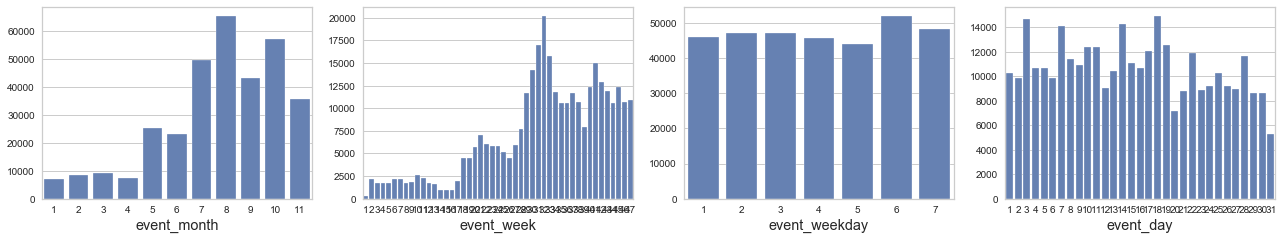

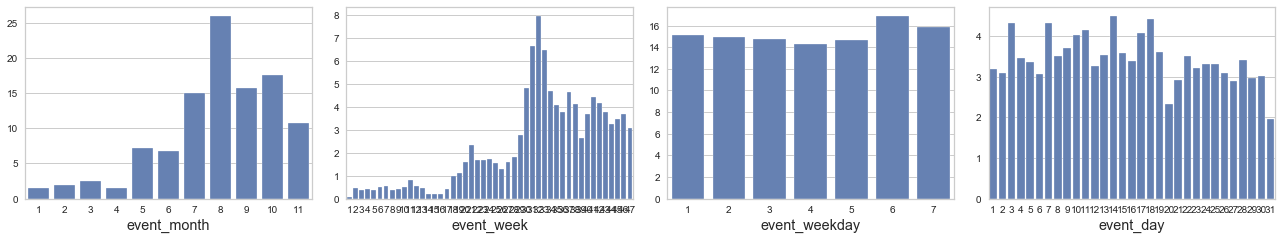

In [10]:
EVENT_TIME_COLS = ['event_month', 'event_week', 'event_weekday', 'event_day']

fig, axs = plt.subplots(1, 4, figsize=(18,3.5))
for i, c in enumerate(EVENT_TIME_COLS):
    df_ = df.groupby(c).order_id.agg('nunique')
    sns.barplot(x=df_.index, y=df_.values, ax=axs[i], color=CLR)
fig.tight_layout()

fig, axs = plt.subplots(1, 4, figsize=(18,3.5))
for i, c in enumerate(EVENT_TIME_COLS):
    df_ = df.groupby(c).price.sum() / 1e6
    sns.barplot(x=df_.index, y=df_.values, ax=axs[i], color=CLR)
fig.tight_layout()

- It seems that number of orders and sales are increasing in 2020. <br>
- However, I think this is driven by the increase in number of registered customers, perhaps in their online store. <br>
- In fact, when plotting all the data including those without user_id, we can see some significant drops perhaps due to lockdowns
- It seems that there are more orders and sale during weekends compared to weekdays

In [11]:
# Check
df.groupby('event_month').user_id.agg('nunique')

event_month
1      1422
2      1848
3      2183
4      4719
5     15472
6     12279
7     27742
8     33292
9     18169
10    13207
11     7686
Name: user_id, dtype: int64

### Look into orders and sales in different categories

- Which categories are bought the most/least?
- Which categories generate the most/least sales?
- Are there low orders but high sales categories? vise versa

#### Top-level categories

,orders,sales,orders_pct,sales_pct
category_code_1,,,,
electronics,142221,56.711950,39.9,53.2
appliances,117494,27.369443,33.0,25.7
computers,59134,19.207413,16.6,18.0
furniture,16478,1.009614,4.6,0.9
stationery,6765,0.062383,1.9,0.1


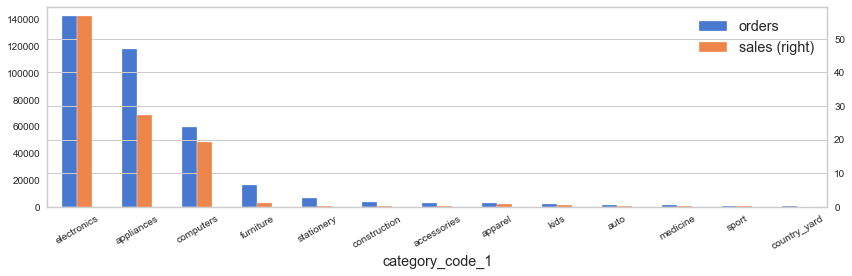

In [12]:
df_ = df.groupby('category_code_1').order_id.agg('nunique').to_frame('orders').join(
        df.groupby('category_code_1').price.sum().to_frame('sales') / 1e6) \
        .sort_values('orders', ascending=False)
        
df_.plot(kind='bar', secondary_y='sales', rot=30, figsize=(12,4))
plt.tight_layout()

total_orders = df_.orders.sum()
total_sales = df_.sales.sum()

df_['orders_pct'] = round(100 * df_.orders  / total_orders, 1)
df_['sales_pct'] = round(100 * df_.sales  / total_sales, 1)
df_.head()

- Electronics, appliances and computers dominated the orders and sales. They account fo 89.5% of all orders and 96.9% of all sales
- This makes sense given that the data is from an electronics store :)

#### Sub-categories of appliances, electronics, computers

,category_code_1,category_code_2,orders,sales,orders_pct,sales_pct
18,electronics,smartphone,94977,41.177571,26.6,38.6
3,appliances,kitchen,72561,21.050327,20.4,19.8
12,computers,notebook,24438,14.772703,6.9,13.9
21,electronics,video,17268,8.762034,4.8,8.2


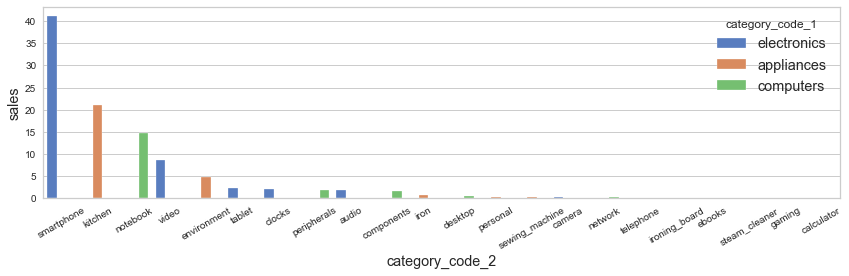

In [13]:
cols = ['appliances', 'electronics', 'computers']
grps = ['category_code_1', 'category_code_2']
df_ = df[df.category_code_1.isin(cols)]
df_ = df_.groupby(grps).order_id.agg('nunique').to_frame('orders').join(
        df_.groupby(grps).price.sum().to_frame('sales') / 1e6) \
                .reset_index().sort_values('sales', ascending=False)
df_['orders_pct'] = round(100 * df_.orders  / total_orders, 1)
df_['sales_pct'] = round(100 * df_.sales  / total_sales, 1)

plt.figure(figsize=(12,4))
sns.barplot(x='category_code_2', y='sales', hue='category_code_1', data=df_)
_ = plt.xticks(rotation=30)
plt.tight_layout()

df_[df_.sales_pct >= 5].head()

- Smartphones account for 26.6% of all orders and 38.6 percent of all sales.
- It might be expected that smarphones, notebooks and kitchen items will dominate during the pandemic given that people will interact more online and cook more at home. <br> However, it's hard to say for sure without comparing this with pre-pandemic levels. Also, as the economy continues to reopen this pandemic tailwind might be over.

#### Bottom-level categories

,category_code_1,category_code_2,category_code_3,orders,sales,category_code_12
18,electronics,smartphone,smartphone,94977,41.177571,electronics-smartphone
17,computers,notebook,notebook,24438,14.772703,computers-notebook
20,electronics,video,tv,17162,8.716818,electronics-video
13,appliances,kitchen,refrigerators,19201,8.574327,appliances-kitchen
16,appliances,kitchen,washer,13793,4.893941,appliances-kitchen


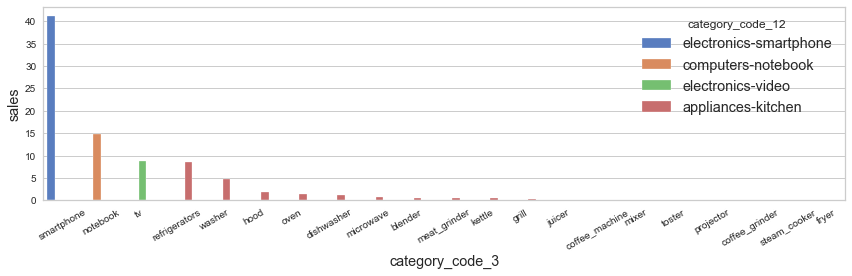

In [14]:
df_ = df.merge(df_[df_.sales_pct >= 5][grps], on=grps)
df_ = df_.groupby(grps+['category_code_3']).order_id.agg('nunique').to_frame('orders').join(
        df_.groupby(grps+['category_code_3']).price.sum().to_frame('sales') / 1e6) \
                .reset_index().sort_values('sales', ascending=False)
df_['category_code_12'] = df_['category_code_1'] + '-' + df_['category_code_2']

plt.figure(figsize=(12,4))
sns.barplot(x='category_code_3', y='sales', hue='category_code_12', data=df_)
_ = plt.xticks(rotation=30)
plt.tight_layout()

df_.head()

### Look into orders and sales in different brands

- Which brands are bought the most/least?
- Which brands generate the most/least sales?
- Are there low orders but high sales brands? vise versa

,orders,sales,orders_pct,sales_pct
brand,,,,
samsung,81085,28.695259,22.7,26.9
apple,33377,25.884147,9.4,24.3
lg,15257,7.718931,4.3,7.2
asus,8932,5.071123,2.5,4.8
lenovo,7821,4.562666,2.2,4.3
bosch,7702,3.053916,2.2,2.9
hp,5939,2.464513,1.7,2.3
xiaomi,11669,2.280438,3.3,2.1
huawei,9345,2.184250,2.6,2.0


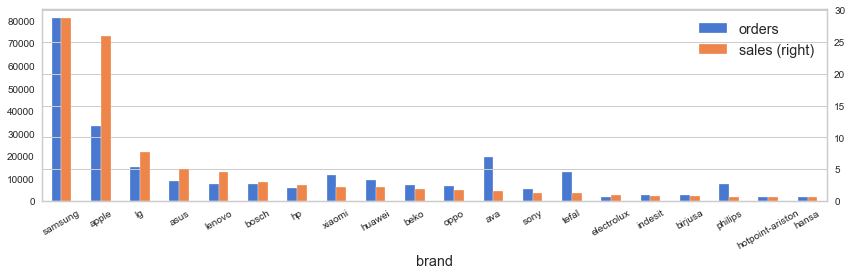

In [15]:
df_ = df.groupby('brand').order_id.agg('nunique').to_frame('orders').join(
        df.groupby('brand').price.sum().to_frame('sales') / 1e6) \
            .sort_values('sales', ascending=False).head(20) 

df_.plot(kind='bar', secondary_y='sales', rot=30, figsize=(12,4))
plt.tight_layout()

df_['orders_pct'] = round(100 * df_.orders / total_orders, 1)
df_['sales_pct'] = round(100 * df_.sales / total_sales, 1)

df_.head(10)

- The most bought brand is Samsung, followed by Apple
- Despite that Apple only accounts for 9.4 of all orders, it accounts for 24.3% of all sales which is just 2.6% behing Samsung.
- Given that Apple product generally (?) have higher profit margins, perhaps the store should try to sell more Apple products to boost their topline and bottomline

#### Compare the different bottom-level categories of Samsung and Apple

,brand,category_code_3,orders,sales,min,mean,max,orders_pct,sales_pct
0,apple,clocks,2619,1.187897,185.16,440.941793,601.83,0.7,1.1
8,samsung,clocks,1487,0.442883,41.64,291.370605,694.42,0.4,0.4
1,apple,cooler,79,0.003335,12.71,42.215823,115.72,0.0,0.0
9,samsung,cooler,4,0.000014,3.47,3.470000,3.47,0.0,0.0
2,apple,hdd,286,0.059324,43.96,195.788152,339.10,0.1,0.1
10,samsung,hdd,1209,0.152232,37.01,123.264964,915.02,0.3,0.1
3,apple,headphone,4045,0.914721,37.01,225.356236,324.05,1.1,0.9
11,samsung,headphone,2927,0.186325,6.23,62.046284,173.59,0.8,0.2
4,apple,notebook,2249,3.292571,92.57,1457.534794,4999.98,0.6,3.1
12,samsung,notebook,2,0.003280,1421.27,1640.020000,1858.77,0.0,0.0


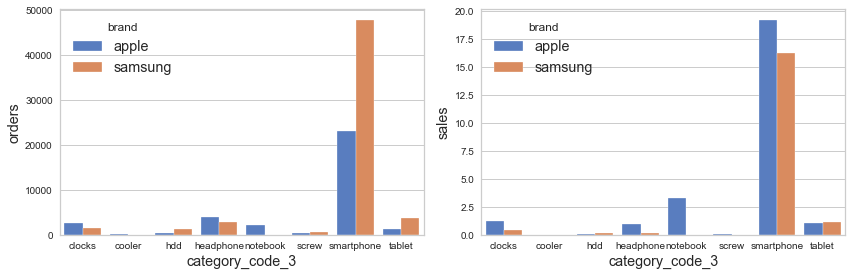

In [16]:
brands = ['samsung', 'apple'] 
common_cat = set(df[df.brand=='apple'].category_code_3) & \
    set(df[df.brand=='samsung'].category_code_3)
grps = ['brand', 'category_code_3']
stats = ['min', 'mean', 'max']

df_ = df[(df.brand.isin(brands)) & (df.category_code_3.isin(common_cat))]
df_ = df_.groupby(grps).order_id.agg('nunique').to_frame('orders').join(
        df_.groupby(grps).price.sum().to_frame('sales') / 1e6).join(
            df_.groupby(grps).price.agg(stats).rename(dict(zip(stats, [x+'_price' for x in stats])))
        ).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(12,4))
for i, c in enumerate(['orders', 'sales']):
    sns.barplot(x='category_code_3', y=c, hue='brand', ax=axs[i], data=df_)
fig.tight_layout()

df_['orders_pct'] = round(100 * df_.orders / total_orders, 1)
df_['sales_pct'] = round(100 * df_.sales / total_sales, 1)

df_.sort_values('category_code_3')

- The store actually generated more sales from Apple smartphones than Samsung smartphones which again despite lower number of orders of Apple
- It seems that users prefer Apple notebooks and headphones but prefer samsung tablets

### Misc.

#### Look into number of products per order

In [17]:
df_ = df.groupby('order_id').product_id.agg(['nunique', 'size'])

print(df_[df_['nunique'] > 1].shape[0] / df_.shape[0])
print((df_['size'] > df_['nunique']).sum())

df_temp = df_.value_counts('nunique', normalize=True) * 100
df_temp[df_temp >= 0.01]

0.17432631241183486
0


nunique
1     82.567369
2     12.106095
3      3.353454
4      1.155152
5      0.425917
6      0.188287
7      0.106858
8      0.042077
9      0.023309
10     0.016952
dtype: float64

- 17.4% of all orders involve  2 or more items/prpoducts
- No same product is bought more than once in a single order.

#### For those orders with more than one product, do they belong in the same category/ brand?

In [18]:
grouper = df[df.order_id.isin(df_[df_['nunique'] > 1].index)].groupby('order_id')

# 33694 same top level category out of 57588
df_temp = grouper.category_code_1.apply(set).apply(len)
print(df_temp[df_temp == 1].shape[0])

# 13722 same brand out of 57588
df_temp = grouper.brand.apply(set).apply(len)
print(df_temp[df_temp == 1].shape[0])

33694
13722


- 58.5% of orders with multiple products belong to the same top-level category
- 23.8% of orders with multiple products belong to the same brand

#### Total sales per order

,sales_per_order
min,0.210000
mean,322.542972
median,196.270000
max,11782.330000


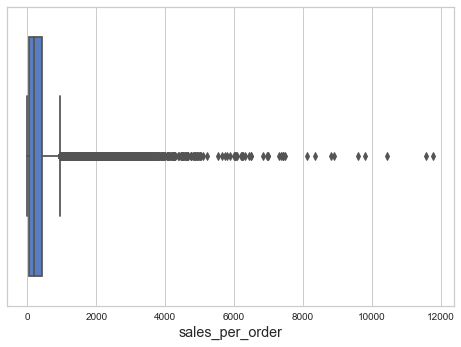

In [19]:
df_ = df.groupby('order_id').price.sum().to_frame('sales_per_order')
_ = sns.boxplot(df_.sales_per_order)
df_.agg(['min', 'mean', 'median', 'max'])

In [20]:
print(100 * df_[df_.sales_per_order <= 50].shape[0] / df_.shape[0])
print(100 * df_[df_.sales_per_order <= 100].shape[0] / df_.shape[0])
print(100 * df_[df_.sales_per_order <= 200].shape[0] / df_.shape[0])
print(100 * df_[df_.sales_per_order <= 500].shape[0] / df_.shape[0])

22.822131946504573
33.30356656354247
51.07886882238623
78.93935449498404


#### Total orders and sales

In [21]:
print(df.order_id.nunique())
print(df.price.sum())

330346
106550780.72999997


# Summary and Recommendations

After preprocessing the data, we only retained ~15.8% (417K out of 2.63M) of all records mainly due to dropping ~78.6% of records without user IDs. <br> 
We have a total of 90,651 unique users. The data are from January 5, 2020 to November 21, 2020 and the total number of orders and sales are 300K and $106.5M respectively.


1. How would you prepare the data for analysis?
    - Check and fix data types and remove duplicates
    - Check and fix missing and unexpected values
    - Create features 
    - Check and fix outliers
<br><br>
2. What insights can you glean just by exploring the data?
    - It seems that number of orders and sales are increasing in 2020. But this seems to be driven by the increase in number of registered customers. <br>
    In fact, when plotting all the data including those without user_id, we can see some significant drops perhaps due to lockdowns.
    - Electronics, appliances and computers dominated the orders and sales. They account fo 89.5% of all orders and 96.9% of all sales
    - Smartphones account for 26.6% of all orders and 38.6 percent of all sales. It might be expected that smarphones, notebooks and kitchen items will dominate during the pandemic given that people will interact more online and cook more at home. However, it's hard to say for sure without comparing this with pre-pandemic levels. 
    - The most bought brand is Samsung, followed by Apple. Despite that Apple only accounts for only 9.4 of all orders, it accounts for 24.3% of all sales which is just 2.6% behind Samsung. <br>
    Also, The store actually generated more sales from Apple smartphones than Samsung smartphones which again despite lower number of orders.
<br><br>
5. What other promotions can you recommend based on customer behavior?
    - Only 17.4% of all orders involve 2 or more items/products. Moreover 58.5% of orders with multiple products belong to the same top-level category <br> and 23.8% of orders with multiple product belong to the same brand: **Bundle products together and offer discounts to increase sales**
    - No same product is bought more than once in a single order: **Offer buy 1 and get the next at a discount. This might encourage them to buy together with a friend/family member**
    - 22.8%, 33.3%, 51.1% of all orders amounts to less than or equal to $50, $100, $200 respectively: **Conduct spend and save/cashback promo i.e. more savings/cashback as they spend more**
    - We only retained ~15.6 of all records, perhaps there are a lot more unregistered customers: **Offer store credits to first time users to encourage customers to register**
    - 47% of users only made an order once: **Develop a loyalty program to encourage more users to buy again and earn some points, similar to ZAP Lotalty Program :D**
    - There are products that are ordered less but whose price and margins are higher e.g. Apple vs Samsung: **recommend them more?**

In [22]:
# TODO: items that are bought more than once by a customer
# x = df.groupby(['user_id', 'order_id']).size()
# x[x > 1].shape[0]

# Customer Segmentation

## Preprocessing


1. Calculate Recency, Frequency and Monetary Value (RFM) metrics of customers
2. Check and fix outliers 
    - If R,F,M are highly skewed. Log-scale then z-score normalize the features.

#### Recency, Frequency and Monetary Value (RFM) metrics of customers

- NOTE: Calculate frequency assuming that today is 1 day + max date on record

In [23]:
RFM_df = (((df.event_date.max() - df.groupby('user_id').event_date.max()) \
            / pd.Timedelta(1,'D')) + 1).to_frame('recency').join(
                df.groupby('user_id').order_id.agg('nunique').to_frame('frequency')).join(
                df.groupby('user_id').price.sum().to_frame('monetary'))
display(RFM_df.head())
RFM_df.describe()

,recency,frequency,monetary
user_id,,,
1.515916e+18,136.0,1,416.64
1.515916e+18,25.0,2,56.43
1.515916e+18,6.0,4,5984.92
1.515916e+18,47.0,5,3646.85
1.515916e+18,131.0,2,182.83


,recency,frequency,monetary
count,90651.000000,90651.000000,90651.000000
mean,101.145393,3.644152,1175.395536
std,54.344883,13.343586,3501.106257
min,1.000000,1.000000,0.210000
25%,65.000000,1.000000,162.010000
50%,103.000000,2.000000,456.000000
75%,129.000000,3.000000,1101.005000
max,322.000000,329.000000,111662.680000


#### Check for and fix outliers

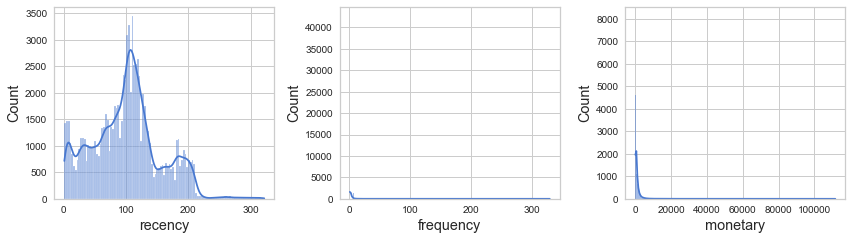

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(12,3.5))
for i, c in enumerate(RFM_df.columns):
    sns.histplot(x=c, kde=True, ax=axs[i], data=RFM_df)
fig.tight_layout()

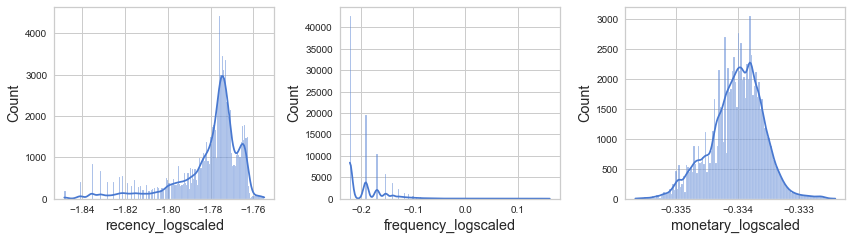

In [25]:
scaler = StandardScaler().fit(RFM_df)
t = np.log(RFM_df+1)
t = scaler.transform(t)

cols = [x+'_logscaled' for x in RFM_df.columns]
RFM_df = pd.DataFrame(t, columns=cols, index=RFM_df.index).join(RFM_df)

fig, axs = plt.subplots(1, 3, figsize=(12,3.5))
for i, c in enumerate(cols):
    sns.histplot(x=c, kde=True, ax=axs[i], data=RFM_df)
fig.tight_layout()

In [26]:
RFM_df.frequency.value_counts(normalize=True).head()

1    0.470905
2    0.214261
3    0.114726
4    0.064776
5    0.039779
Name: frequency, dtype: float64

- RFM metrics are skewed.
- 47% of users only made an order once
- Median recency is 103 days. I think this is reasonable given smartphone, laptops, tv, refrigirator are most common items bought and these are not items that we buy every month.

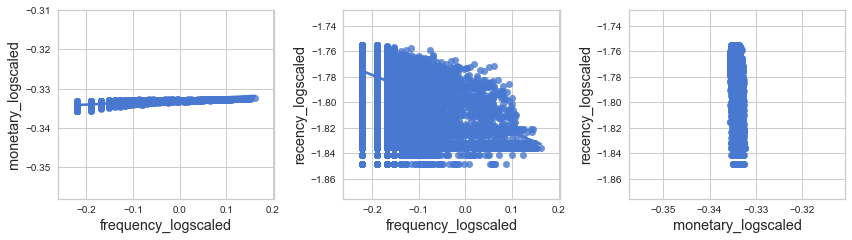

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(12,3.5))
sns.regplot(x='frequency_logscaled', y='monetary_logscaled', ax=axs[0], data=RFM_df)
sns.regplot(x='frequency_logscaled', y='recency_logscaled', ax=axs[1], data=RFM_df)
sns.regplot(x='monetary_logscaled', y='recency_logscaled', ax=axs[2], data=RFM_df)
plt.tight_layout()

- Customers who buy more frequently are more like to spend more

## Segmentation

1. Choose optimal number of clusters
    - To simplify, just use elbow method for now.
    - TODO: Try silhouette and CH scores as metric
2. Clustering
    - Our data is simple and I think we'll generally see similar trends e.g. a cluster with frequent buyers and high spenders
    - To simplify
        - we will only try K-means as baseline and final model without tuning the model
            - In practice, we would want to try different models then choose a baseline model. After that we tune the baseline model to have the final model
        - we will not compare and charaterize different number of clusters.
            - In practice, there might be cases where we want a different number of clusters based on domain knowledge than what is algorithmically determined
3. Visualize and characterize clusters and recommend promotions for each group.

#### Choose optimal number of clusters

- NOTE: KElbowVisualizer uses `distortion` as default metric. It can also be set to `silhouette` or `calinski_harabasz`.

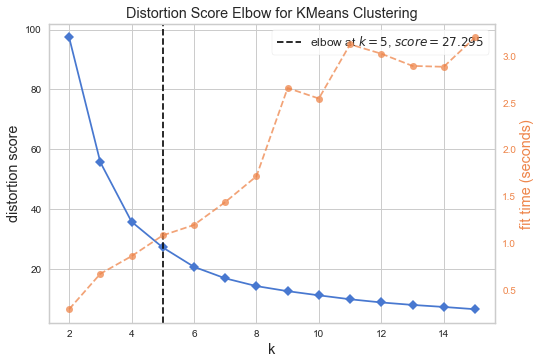

In [28]:
model = KMeans(random_state=100)

visualizer = KElbowVisualizer(model, k=15, random_state=100)
visualizer.fit(RFM_df[cols])   
visualizer.show()

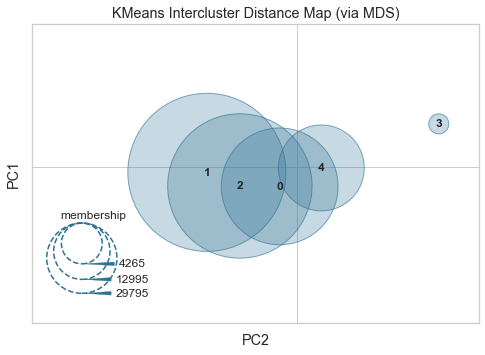

In [29]:
# Intercluster distance map
model = KMeans(n_clusters=5, random_state=11)
visualizer = InterclusterDistance(model, random_state=100)
visualizer.fit(RFM_df[cols])   
visualizer.show()

- The groups are overlapping

#### Clustering

In [30]:
km_model = model.fit(RFM_df[cols])
RFM_df['label'] = km_model.labels_

#### Compare distribution of RFM metrics among cluster

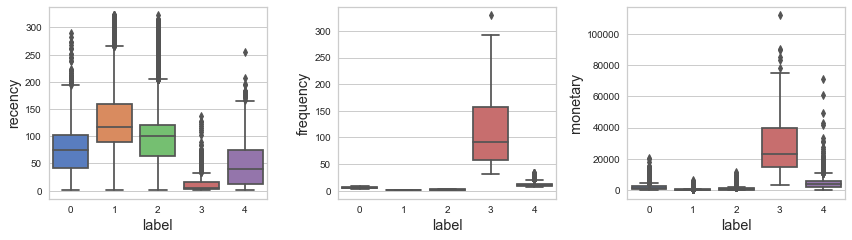

In [31]:
fig, axs = plt.subplots(1, 3, figsize=(12,3.5))
cols = ['recency', 'frequency', 'monetary']
for i,c in enumerate(cols):
        sns.boxplot(data=RFM_df, x='label', y=c, ax=axs[i])
plt.tight_layout()

#### Characterize groups based on cluster centers

In [32]:
cluster_centers = np.exp(scaler.inverse_transform(km_model.cluster_centers_)) -1
clusters_df = pd.DataFrame(cluster_centers,columns=['recency', 'frequency','monetary']).join(
        RFM_df.label.value_counts().to_frame('num_user')).join(
        RFM_df.label.value_counts(normalize=True).to_frame('percent_num_user')*100).join(
        RFM_df.groupby('label').frequency.sum().to_frame('total_frequency')).join(
        RFM_df.groupby('label').monetary.sum().to_frame('total_monetary'))
clusters_df['percent_total_frequency'] = 100 * clusters_df.total_frequency /clusters_df.total_frequency.sum()
clusters_df['percent_total_monetary'] = 100 * clusters_df.total_monetary /clusters_df.total_monetary.sum()
clusters_df.round(2)

,recency,frequency,monetary,num_user,percent_num_user,total_frequency,total_monetary,percent_total_frequency,percent_total_monetary
0,58.90,4.83,1360.04,12995,14.34,63794,23602511.59,19.31,22.15
1,102.50,1.00,166.13,42688,47.09,42688,13908875.63,12.92,13.05
2,77.65,2.32,531.30,29795,32.87,69962,24258811.79,21.18,22.77
3,7.45,95.64,23367.29,908,1.00,103641,25500677.39,31.37,23.93
4,30.12,11.08,3538.76,4265,4.70,50261,19279904.33,15.21,18.09


1. `Cluster 3`: Users here buy most recently, most frequently and spend the most. This is ideally what we want for all our customers. However, this group has the least number users, a whopping 1%.
    - We want to retain our most valuable customers by keeping them satisfied. Perhaps, recognize them and give them some exclusive discounts or freebies to make them feel special.
<br><br>
2. `Clusters 4`: Next in line to our ideal group. We want to increase the number of users in `Cluster 3` and these users are potentially the easiest to convert into the 'most valuable' status.
    - Perhaps, offer them deals on similar items that they usually buy. E.g. when they bought an Iphone before, offer a discount if they buy the new Iphone. This will make them anticipate their next purchase.
<br><br>
3. `Clusters 0 & 2`: Users in these clusters are average customers. Perhaps onduct spend and save/cashback promo i.e. more savings/cashback as they spend more to boost orders/sales of this group
<br><br>
4. `Cluster 1`: This is the worst group. This is the opposite of `Cluster 3`. Users here buy least recently, least frequently and spend the least. On top of that, 47% of our users belong here. <br> Maybe these people are not really into electronic products and they will be the hardest to boost
    - Perhaps offer them irresistable offers that will increase the probability of conversion. Also, help them discover that there are more to our store than the one-time purchase that they made

# Summary and Next Steps

We were able to cluster our users into five groups. Our most valuable customers are grouped in one cluster that is characterized by most recent, most frequent and highest spend. However, this is the smallest group by number of users. On the other hand, our least valuable customers are grouped in another cluster with opposite characteristics as our most valueable customers. 


The five groups are overlapping and to potentially improve the quality of our segmentation, we might want to: 
1. Add other potent features such as:
    - Customer demographics such as age
    - Financial capacity
    - Product brand/category
2. Try other metric to determine optimal number of clusters and try different clustering algorithms and tune the models